# EPA1361 - Model-Based Decision Making

## Multi-model analysis

This exercise uses a simple version of the [Lotka-Volterra predator-prey equations](https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations) to show how the EMA Workbench can be used for a
multi-model analysis, in addition to typical parametric/structural uncertainties. This will let you test the connectors provided in the Workbench for Excel, NetLogo, and Vensim / PySD; we'll also use the models for the sensitivity analysis exercise in week 3.

* Using the three model files provided and the Python function below, define model objects for each implementation (Excel, NetLogo, Vensim/PySD, and Python), and test them using a single ensemble. Use 50 experiments sampled from the parameters below (so that each experiment will be executed for the 4 models, for a total of 200), and retrieve outputs for the _TIME_, _predators_, and _prey_ variables.
    * excel and vensim are only supported on windows
    * vensim requires the DSS version of Vensim
    * Netlogo supoprt depends on [jpype](http://jpype.readthedocs.io/en/latest/install.html) and [pynetlogo](https://pynetlogo.readthedocs.io/en/latest/). Also, if you don't have NetLogo installed, please get it from [NetLogo 6.1.1](https://ccl.northwestern.edu/netlogo/download.shtml) 
    * for pysd, see [its documentation](http://pysd.readthedocs.io/en/master/installation.html)
    * If possible try to work with all model versions, but even 2 or 3 (pure python and something else should be sufficient).
    

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |
|Final time	    |365	    |
|dt	    |0.25	    |

* Note that your EMA Workbench installation includes example scripts for the different connectors. The different model objects follow a similar syntax but will need to be slightly adjusted depending on the software (e.g. to specify the NetLogo run length or the sheet name in Excel). 

* These model objects can be used with a replication functionality (for instance to test the effect of stochastic uncertainty in a NetLogo model), which repeats a given experiment over multiple replications. You can use a single replication in this exercise as the models are not stochastic. By default, each outcome array will then have a shape of (# experiments, # replications, # time steps). Try adapting the outcome arrays so that they can be used with the _lines_ plotting function of the Workbench, and plot the results grouped by model.

* To check the graphical results, find the maximum absolute error of the time series you obtained for the _prey_ variable in the Excel, NetLogo, and Vensim/PySD models, relative to the Python function. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments,
                           ema_logging, SequentialEvaluator)

from ema_workbench.connectors.netlogo import NetLogoModel
from ema_workbench.connectors.excel import ExcelModel
from ema_workbench.connectors.pysd_connector import PysdModel

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis.plotting import lines, Density


def PredPrey(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, final_time=365, reps=1):

    #Initial values
    predators, prey, sim_time = [np.zeros((reps, int(final_time/dt)+1)) for _ in range(3)]
    
    for r in range(reps):
        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

        #Calculate the time series
        for t in range(0, sim_time.shape[1]-1):

            dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
            dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

            prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
            predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
            sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

C:\Users\Eigenaar\anaconda3\envs\MBDM\lib\site-packages\ema_workbench\connectors\__init__.py:17: ImportWarning: vensim connector not available
  warnings.warn("vensim connector not available", ImportWarning)


In [2]:
py_model = Model('PredPreyPy', function=PredPrey)

py_model.uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                       RealParameter('predation_rate', 0.0005, 0.003),
                      RealParameter('predator_efficiency', 0.0001, 0.004),
                      RealParameter('predator_loss_rate', 0.004, 0.08)]

py_model.outcomes = [TimeSeriesOutcome('TIME'),
                  TimeSeriesOutcome('predators'),
                  TimeSeriesOutcome('prey')]

In [3]:
excel_model = ExcelModel('PredPreyExcel', wd=r'./model/', model_file='PredPrey.xlsx', default_sheet = 'Sheet1')

excel_model.uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                       RealParameter('predation_rate', 0.0005, 0.003),
                      RealParameter('predator_efficiency', 0.0001, 0.004),
                      RealParameter('predator_loss_rate', 0.004, 0.08)]

excel_model.outcomes = [TimeSeriesOutcome('TIME'),
                  TimeSeriesOutcome('predators'),
                  TimeSeriesOutcome('prey')]

In [4]:
netlogo_model = NetLogoModel('PredPreyNetlogo', wd=r'./model/', model_file='PredPrey.nlogo')
netlogo_model.run_length = 1460
netlogo_model.replications = 1
netlogo_model.uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                       RealParameter('predation_rate', 0.0005, 0.003),
                      RealParameter('predator_efficiency', 0.0001, 0.004),
                      RealParameter('predator_loss_rate', 0.004, 0.08)]

netlogo_model.outcomes = [TimeSeriesOutcome('TIME'),
                  TimeSeriesOutcome('predators'),
                  TimeSeriesOutcome('prey')]

In [5]:
pysd_model = PysdModel('PredPreyPysd', mdl_file=r'./model/PredPrey.mdl')

pysd_model.uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                       RealParameter('predation_rate', 0.0005, 0.003),
                      RealParameter('predator_efficiency', 0.0001, 0.004),
                      RealParameter('predator_loss_rate', 0.004, 0.08)]

pysd_model.outcomes = [TimeSeriesOutcome('TIME'),
                  TimeSeriesOutcome('predators'),
                  TimeSeriesOutcome('prey')]

In [6]:
ema_logging.log_to_stderr(ema_logging.INFO)
experiments, outcomes = perform_experiments([py_model, excel_model, pysd_model, netlogo_model],50)

[MainProcess/INFO] performing 50 scenarios * 1 policies * 4 model(s) = 200 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 140 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] 180 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] experiments finished


In [7]:
for i in outcomes.keys():
    outcomes[i] = outcomes[i][:,0,:]

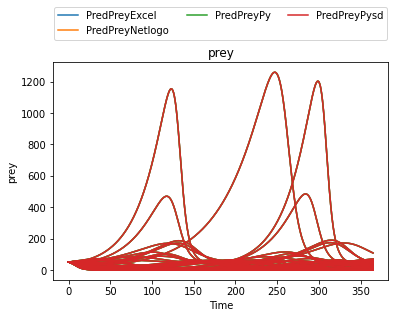

In [8]:
# plot the outcomes for all the models
for outcome in outcomes.keys():
    if outcome == "prey":
        lines(experiments, outcomes, outcomes_to_show = outcome, group_by = 'model', legend=True)

Its all red so that shows that the outcomes (at least visually) are the same over all models.

In [9]:
# focus on only the prey outcomes and turn into dataframe
outcomes_prey = outcomes['prey']
outcomes_prey = pd.DataFrame(outcomes_prey)

In [10]:
# save per model
outcomes_prey_py = outcomes_prey.iloc[:50,:]
outcomes_prey_exc = outcomes_prey.iloc[50:100,:]
outcomes_prey_exc = outcomes_prey_exc.reset_index()
outcomes_prey_pys = outcomes_prey.iloc[100:150,:]
outcomes_prey_pys = outcomes_prey_pys.reset_index()
outcomes_prey_nl = outcomes_prey.iloc[150:,:]
outcomes_prey_nl = outcomes_prey_nl.reset_index()

In [13]:
# subtract the matrices to find the errors
diff_outc_py_exc = outcomes_prey_py.subtract(outcomes_prey_exc)
diff_outc_py_exc = diff_outc_py_exc.abs()
diff_outc_py_pys = outcomes_prey_py.subtract(outcomes_prey_pys)
diff_outc_py_pys = diff_outc_py_pys.abs()
diff_outc_py_nl = outcomes_prey_py.subtract(outcomes_prey_nl)
diff_outc_py_nl = diff_outc_py_nl.abs()

In [14]:
# maximum absolute error between the excel, pysd, and netlogo model
print("maximum error between the python/excel model:",diff_outc_py_exc.max().max())
print("maximum error between the python/pysd model:",diff_outc_py_pys.max().max())
print("maximum error between the python/nl model:",diff_outc_py_nl.max().max())

maximum error between the python/excel model: 0.0
maximum error between the python/pysd model: 5.115907697472721e-13
maximum error between the python/nl model: 2.7966962079517543e-11


These values are all (very close to) 0, which validates what we concluded visually above. 